In [130]:
#import antigravity
import pandas as pd
import math
from typing import List
from datetime import datetime
from sqlalchemy import MetaData, Table, create_engine, text
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
engine = create_engine('sqlite:///pare.db')

In [4]:
import sys
import os

In [132]:
sys.path.append(os.path.join(os.path.dirname('__file__'), 'models'))
sys.path.append(os.path.join(os.path.dirname('__file__'), 'scripts'))
sys.path.append(os.path.join(os.path.dirname('__file__'), 'config'))

In [131]:
from models.person import Person, Sex, TypePerson
from models.department import Department
from models.commune import Commune
from models.section import Section
from models.community import Community

In [7]:
from scripts.utils import random_item, random_date, random_date_between, random_int, years_between

In [133]:
from config.params import DEBUG

In [8]:
haitian_names = pd.read_csv("./inputs/haitian_names.csv", encoding="latin-1")
kobo_df = pd.read_csv("./inputs/kobo_local.csv", encoding="latin-1")

In [9]:
h_fnames = list(haitian_names['FirstName'])

In [10]:
h_mnames = list(haitian_names['MiddleName'])

In [11]:
h_lnames = list(haitian_names['LastName'])

In [12]:
def get_fullname():
    f_name = random_item(h_fnames)
    m_name = random_item(h_mnames)
    l_name = random_item(h_lnames).upper()
    name = ""
    if isinstance(m_name, float):
        name = (f_name + " " + l_name).strip()
    else:
        if m_name != 'nan':
            name = (f_name + " " + m_name + " " + l_name).strip()
        else:
            name = (f_name + " " + m_name + " " + l_name).strip()
    return name

In [13]:
def get_first_name(h_fnames, h_mnames):
    f_name = random_item(h_fnames)
    m_name = random_item(h_mnames)
    name = ""
    if isinstance(m_name, float):
        name = f_name
    else:
        if m_name != 'nan':
            name = (f_name + " " + m_name).strip()
        else:
            name = (f_name).strip()
    return name


def get_last_name(h_lnames):
    return random_item(h_lnames)

In [14]:
departments_with_structure = (
    kobo_df.groupby(['Departements', 'Communes', 'Section communale/Ville', 'Communauté/Addresse'])['Coordonnée GPS']
    .first()
    .reset_index()
    .groupby(['Departements', 'Communes', 'Section communale/Ville'])
    .apply(lambda x: x[['Communauté/Addresse', 'Coordonnée GPS']].to_dict(orient='records'), include_groups=False)
    .reset_index(name='Communauté/Addresse')
    .groupby(['Departements', 'Communes'])
    .apply(lambda x: x[['Section communale/Ville', 'Communauté/Addresse']].to_dict(orient='records'), include_groups=False)
    .reset_index(name='Section communale/Ville')
    .groupby('Departements')
    .apply(lambda x: x[['Communes', 'Section communale/Ville']].to_dict(orient='records'), include_groups=False)
    .reset_index(name='Communes')
)
result4 = departments_with_structure.to_dict(orient='records')

In [15]:
def get_department(data: list) -> dict:
    return random_item(data)

def get_commune(data: list) -> dict:
    return random_item(data)

def get_section(data: list) -> dict:
    return random_item(data)

def get_community(data: list) -> dict:
    return random_item(data)    

def get_gps_location(community: dict) -> tuple:
    gps_location = community['Coordonnée GPS'] 
    if gps_location is None:
        return (0,0) 
    if gps_location == '':
        return (0,0)
    gps_parts = gps_location.split(" ")
    return (float(gps_parts[0]), float(gps_parts[1])) 

In [16]:
department_list = []
commune_list = []
section_list = []
community_list =[]
i = 1
j = 1
k = 1
l=1
for dep in result4:
    department= Department(
        id=i,
        name = dep['Departements']
    )
    department_list.append(department)
    communes = dep['Communes']
    for com in communes:
        commune = Commune(
            id=j,
            name=com['Communes'],
            department_id=i
        )
        commune_list.append(commune)
        sections = com['Section communale/Ville']
        
        for sec in sections:
            section = Section(
                id=k,
                name=sec['Section communale/Ville'],
                commune_id=j
            )
            section_list.append(section)
            communities = sec['Communauté/Addresse']
            for comm in communities:
                gps = get_gps_location(comm)
                community = Community(
                    id=l,
                    name=comm['Communauté/Addresse'],
                    section_id=k,
                    gps_lat=gps[0],
                    gps_lng=gps[1]
                )
                community_list.append(community)
                l = l+1
            k = k + 1
        j = j + 1
    i = i + 1

In [17]:
departments_dicts = [depart.dict() for depart in department_list]
depart_df = pd.DataFrame(departments_dicts)

In [18]:
communes_dicts = [com.dict() for com in commune_list]
com_df = pd.DataFrame(communes_dicts)

In [19]:
section_dicts = [sec.dict() for sec in section_list]
sec_df = pd.DataFrame(section_dicts)

In [20]:
comm_dicts = [comm.dict() for comm in community_list]
comm_df = pd.DataFrame(comm_dicts)

In [21]:
depart_df.to_sql('departments', con=engine, if_exists='replace', index=False)
com_df.to_sql('communes', con=engine, if_exists='replace', index=False)
sec_df.to_sql('sections', con=engine, if_exists='replace', index=False)
comm_df.to_sql('communities', con=engine, if_exists='replace', index=False)

226

In [22]:
birth_date_start = datetime(1940, 1, 1)
birth_date_end = datetime(2009, 1, 1)

joined_start_date = datetime(2024, 1, 1)
joined_end_date = datetime(2027, 12, 31)

In [23]:
total_participants = 30140

In [134]:
participants = []
if not DEBUG:
    sexes = [Sex.male, Sex.female]
    type_p = [TypePerson.type_1, 
              TypePerson.type_2, 
              TypePerson.type_3, 
              TypePerson.type_4, 
              TypePerson.type_5, 
              TypePerson.type_6]
    
    for i in range(total_participants):
        #department = get_department(result4)
        #commune = get_commune(department["Communes"])
        #section = get_section(commune['Section communale/Ville'])
        #community = get_community(section['Communauté/Addresse'])
        #gps = get_gps_location(community)
        community = random_item(community_list)
        
        person: Person = Person(
               first_name = get_first_name(h_fnames, h_mnames),
               last_name = get_last_name(h_lnames),
               sex=random_item(sexes).value,
               address=community.name,
               community_id = community.id,
               phone_1='33511661',
               birth_date = random_date_between(birth_date_start, birth_date_end),
               date_joined = random_date_between(joined_start_date, joined_end_date ),
               nb_goat = random_int(0, 25),
               nb_cattle= random_int(0, 10),
               nb_sheep = random_int(0, 25),
               nb_poultry = random_int(0, 100),
               gps_lat = community.gps_lat,
               gps_lng = community.gps_lng,
               type_person = random_item(type_p).value
        )
        participants.append(person)

In [25]:
participants
people_dicts = [person.dict() for person in participants]
df = pd.DataFrame(people_dicts)

In [26]:
today = datetime.today()

In [27]:
ages = [years_between(today.date(), d) for d in df['birth_date']]

In [28]:
df['age'] = ages

In [29]:
age_group = ['15-29' if age < 30 else '30+' for age in df['age']]

In [30]:
df['age_group'] = age_group

In [31]:
df.groupby('age_group').count()

,id,first_name,last_name,address,sex,birth_date,birth_year,age,type_person,type_id,...,phone_1,phone_2,nb_goat,nb_cattle,nb_sheep,nb_poultry,gps_lat,gps_lng,date_joined,community_id
age_group,,,,,,,,,,,,,,,,,,,,,
15-29,0,6300,6300,6300,6300,6300,0,6300,6300,0,...,6300,0,6300,6300,6300,6300,6300,6300,6300,6300
30+,0,23840,23840,23840,23840,23840,0,23840,23840,0,...,23840,0,23840,23840,23840,23840,23840,23840,23840,23840


In [32]:
#df.to_csv('./outputs/participants.csv')
df['id'] = range(1, len(df) + 1)

In [33]:
df.to_sql('participants', con=engine, if_exists='replace', index=False)

30140

In [34]:
df_from_sql = pd.read_sql('participants', con=engine)

df_from_sql.head()

,id,first_name,last_name,address,sex,birth_date,birth_year,age,type_person,type_id,...,phone_2,nb_goat,nb_cattle,nb_sheep,nb_poultry,gps_lat,gps_lng,date_joined,community_id,age_group
0,1,Claire-Heureuse,MASUCCI,"#002, Rue Bellevue palais -Roi",Male,2007-02-02,None,17,Personnes travaillant dans des entreprises du ...,None,...,None,3,7,17,43,19.666851,-72.127627,2025-10-19,52,15-29
1,2,Alain,ANISETTE,Mérande,Male,1951-12-14,None,72,Personnes travaillant dans des entreprises du ...,None,...,None,18,6,5,47,19.611705,-71.765699,2027-02-15,109,30+
2,3,Geffrard,DUPERVAL,Dilaire,Female,1965-11-07,None,58,Petit producteur,None,...,None,4,6,9,75,19.548422,-71.766785,2024-11-30,134,30+
3,4,Pierre-Eddy,AZEMAR,Mayaya,Male,1964-11-04,None,59,Producteur non-petit exploitant,None,...,None,5,5,3,52,19.346727,-72.020093,2024-12-08,41,30+
4,5,Serge,COFI,Lapatie,Female,1971-05-04,None,53,Les gens au gouvernement,None,...,None,1,9,24,69,19.144129,-71.952485,2024-06-26,10,30+


In [36]:
#from sqlalchemy import text

# Use `text()` to execute raw SQL queries
#with engine.connect() as conn:
#    result = conn.execute(text("SELECT * FROM participants WHERE age > 30"))
#    for row in result:
#        print(row)

In [37]:
#df_query = pd.read_sql('SELECT * FROM participants WHERE age > 30', con=engine)

#df_query.head()

In [38]:
s = df.groupby("age_group")[['id']].count()

In [97]:
s = df.groupby("age_group")[['id']].count()
s["% age"] = [ str(round((x/total_participants) * 100, 2)) + '%'  for x in s['id']]

In [98]:
s

,id,% age
age_group,,
15-29,6300,20.9%
30+,23840,79.1%


In [56]:
# Set up the engine and metadata
metadata = MetaData()

# Reflect the existing tables
community_table = Table('communities', metadata, autoload_with=engine)
section_table = Table('sections', metadata, autoload_with=engine)
commune_table = Table('communes', metadata, autoload_with=engine)
department_table = Table('departments', metadata, autoload_with=engine)

In [77]:
from sqlalchemy import select

# Create the join query
query = (
    select(
        community_table.c.id.label('community_id'),
        community_table.c.name.label('community_name'),
        section_table.c.name.label('section_name'),
        commune_table.c.name.label('commune_name'),
        department_table.c.name.label('department_name')
    )
    .select_from(
        community_table
        .join(section_table, community_table.c.section_id == section_table.c.id)
        .join(commune_table, section_table.c.commune_id == commune_table.c.id)
        .join(department_table, commune_table.c.department_id == department_table.c.id)
    )
)

In [78]:
comm_list = []
with engine.connect() as conn:
    result = conn.execute(query)
    fetched_communities = result.fetchall()
    
    for row in fetched_communities:
        comm_list.append(dict(row._mapping))

In [79]:
c_df = pd.DataFrame(comm_list)

In [80]:
c_df.head()

,community_id,community_name,section_name,commune_name,department_name
0,1,Trois Bois Pin,Cerca-Carvajal,Cerca-Carvajal,Centre
1,2,Bois Couleuvre,Rang,Cerca-Carvajal,Centre
2,3,Marinette,Rang,Cerca-Carvajal,Centre
3,4,Nan Guerrier/ Trois Boipins,Rang,Cerca-Carvajal,Centre
4,5,Trois Boipins,Rang,Cerca-Carvajal,Centre


In [81]:
c_df.to_sql('temp_communities', con=engine, if_exists='replace', index=False)

226

In [82]:
c_ids = df['community_id']

In [93]:
depart_names = []
comm_names = []
section_names = []
community_names = []
with engine.connect() as conn:
    for _id in c_ids:
        result = conn.execute(text(f"SELECT * FROM temp_communities WHERE community_id = :id"), {"id": _id})
        row = result.fetchone()
        if row:
            r = dict(row._mapping)
            depart_names.append(r['department_name'])
            comm_names.append(r['commune_name'])
            section_names.append(r['section_name'])
            community_names.append(r['community_name'])
        else:
            depart_names.append("")
            comm_names.append("")
            section_names.append("")
            community_names.append("")
            print(f"No community found with id={_id}")

In [94]:
df["department_name"] = depart_names
df["commune_name"] = comm_names
df["section_name"] = section_names
df["community_name"] = community_names

In [95]:
df.head()

,id,first_name,last_name,address,sex,birth_date,birth_year,age,type_person,type_id,...,nb_poultry,gps_lat,gps_lng,date_joined,community_id,age_group,department_name,commune_name,section_name,community_name
0,1,Claire-Heureuse,MASUCCI,"#002, Rue Bellevue palais -Roi",Male,2007-02-02,None,17,Personnes travaillant dans des entreprises du ...,None,...,43,19.666851,-72.127627,2025-10-19,52,15-29,Nord,Limonade,Centre ville,"#002, Rue Bellevue palais -Roi"
1,2,Alain,ANISETTE,Mérande,Male,1951-12-14,None,72,Personnes travaillant dans des entreprises du ...,None,...,47,19.611705,-71.765699,2027-02-15,109,30+,Nord-Est,Ferrier,Première section,Mérande
2,3,Geffrard,DUPERVAL,Dilaire,Female,1965-11-07,None,58,Petit producteur,None,...,75,19.548422,-71.766785,2024-11-30,134,30+,Nord-Est,Ouanaminthe,Haut Maribahoux (première section),Dilaire
3,4,Pierre-Eddy,AZEMAR,Mayaya,Male,1964-11-04,None,59,Producteur non-petit exploitant,None,...,52,19.346727,-72.020093,2024-12-08,41,30+,Nord,La Victoire,Vieux Lavictoire,Mayaya
4,5,Serge,COFI,Lapatie,Female,1971-05-04,None,53,Les gens au gouvernement,None,...,69,19.144129,-71.952485,2024-06-26,10,30+,Centre,Hinche,Aguaedionne Rive Droite,Lapatie


In [96]:
df.to_csv('./outputs/participants.csv')

In [99]:
s = df.groupby("department_name")[['id']].count()
s["% per department"] = [ str(round((x/total_participants) * 100, 2)) + '%'  for x in s['id']]

In [128]:
#s

In [101]:
s = df.groupby("commune_name")[['id']].count()
s["% per commune"] = [ str(round((x/total_participants) * 100, 2)) + '%'  for x in s['id']]

In [127]:
#s

In [114]:
import numpy as np

# List of ages
ages = df['age']

# Calculate quartiles
q1 = np.percentile(ages, 25)
q2 = np.percentile(ages, 50)
q3 = np.percentile(ages, 75)

print(f"First quartile (Q1): {q1}")
print(f"Second quartile (Q2 - Median): {q2}")
print(f"Third quartile (Q3): {q3}")

First quartile (Q1): 33.0
Second quartile (Q2 - Median): 50.0
Third quartile (Q3): 67.0


In [108]:
min(ages)

15

In [109]:
max(ages)

84

In [121]:
# Calculate quartiles
#q1 = ages.quantile(0.25)
#q2 = ages.quantile(0.50)
#q3 = ages.quantile(0.75)

#print(f"First quartile (Q1): {q1}")
#print(f"Second quartile (Q2 - Median): {q2}")
#print(f"Third quartile (Q3): {q3}")

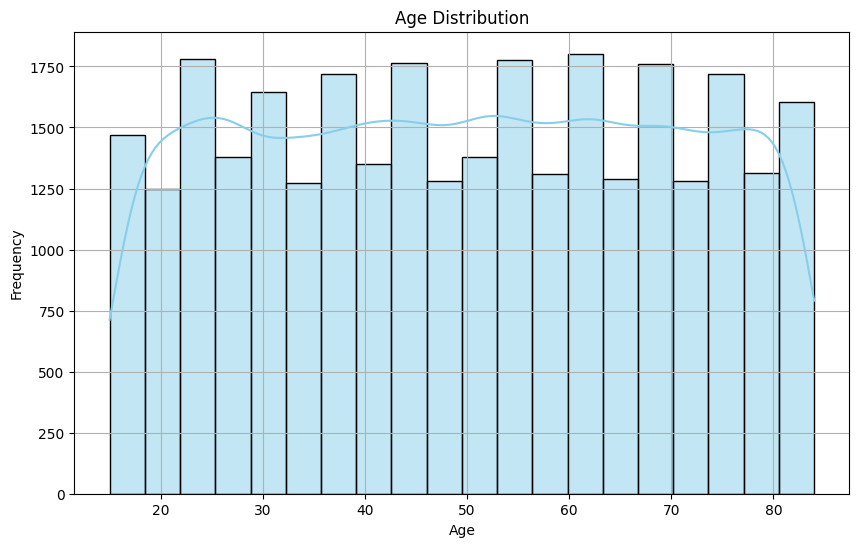

In [120]:
# Create a seaborn style histogram
plt.figure(figsize=(10, 6))
sns.histplot(ages, bins=20, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.show()


In [118]:
# Create a histogram
#plt.figure(figsize=(10, 6))
#plt.hist(ages, bins=10, edgecolor='black', alpha=0.7)
#plt.title('Age Distribution')
#plt.xlabel('Age')
#plt.ylabel('Frequency')
#plt.grid(True)

# Show the plot
#plt.show()


In [126]:
# Convert the 'date' column to datetime format
df['date_joined'] = pd.to_datetime(df['date_joined'])

# Extract the year from the 'date' column and add it as a new column
df['year'] = df['date_joined'].dt.year

# Group by the 'year' column
grouped_by_year = df.groupby('year')[['id']].count()
grouped_by_year["% per year"] = [ str(round((x/total_participants) * 100, 2)) + '%'  for x in grouped_by_year['id']]

print(grouped_by_year)

        id % per year
year                 
2024  7618     25.28%
2025  7438     24.68%
2026  7495     24.87%
2027  7589     25.18%
